#Install and Import required libraries

In [ ]:
!pip install pyLDAvis==3.4.0
!pip install gensim
!pip install requests zstandard tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.5 MB/s eta 0:00:00


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LsiModel, Phrases, LdaModel, TfidfModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.matutils import corpus2csc
import pyLDAvis.lda_model
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import spacy
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Data Acquisition

In this section we will download data from the reddit archives, extract and convert them into a format that is suitable for our project.

In [ ]:
import requests
import zstandard as zstd
import pandas as pd
import os
from tqdm.auto import tqdm
import json

# Function to download a file
def download_file(url, filename):
  if os.path.exists(filename):
    return
  response = requests.get(url, stream=True)
  with open(filename, "wb") as f:
    f.write(response.content)

# Function to decompress a ZST File
def decompress_zst(input_file, output_file):
  if os.path.exists(output_file):
    return
  decompressor = zstd.ZstdDecompressor()
  with open(input_file, "rb") as ifh:
    with open(output_file, "wb") as ofh:
      decompressor.copy_stream(ifh, ofh)

# input file is jsonl in utf8 encoding
# keep condition is a lamba accepting a post, and returns boolean whether to include it in dataframe or not.
# returns a pandas dataframe
def make_dataset(input_file, output_file, keep_condition= None):
  if os.path.exists(output_file):
    return

  posts = []
  count = 0
  with open(input_file, "r", encoding='utf8') as file:
    for line in tqdm(file):
        post = json.loads(line)
        if keep_condition(post):
            posts.append(post)
            count += 1
        if count == 50000:  # limiter for 50,000 maximum
            break
  df = pd.DataFrame(posts)
  df = df[['selftext']]
  df.rename(columns= {'selftext': 'document'} , inplace=True)
  df=df.drop_duplicates().dropna().reset_index(drop=True)
  df.to_csv(output_file, index=False)
  return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
archive_urls = [
    "https://the-eye.eu/redarcs/files/islam_submissions.zst",
    "https://the-eye.eu/redarcs/files/technology_submissions.zst",
    "https://the-eye.eu/redarcs/files/science_submissions.zst",
    "https://the-eye.eu/redarcs/files/food_submissions.zst",
    "https://the-eye.eu/redarcs/files/gaming_submissions.zst",
    "https://the-eye.eu/redarcs/files/travel_submissions.zst",
    "https://the-eye.eu/redarcs/files/personalfinance_submissions.zst",
    "https://the-eye.eu/redarcs/files/sports_submissions.zst",
    "https://the-eye.eu/redarcs/files/television_submissions.zst",
    "https://the-eye.eu/redarcs/files/Fitness_submissions.zst",
    "https://the-eye.eu/redarcs/files/AskReddit_submissions.zst",
    "https://the-eye.eu/redarcs/files/atheism_submissions.zst",
    "https://the-eye.eu/redarcs/files/Christianity_submissions.zst",
    "https://the-eye.eu/redarcs/files/hinduism_submissions.zst",
    "https://the-eye.eu/redarcs/files/Muslim_submissions.zst",
    "https://the-eye.eu/redarcs/files/Hijabis_submissions.zst",
    "https://the-eye.eu/redarcs/files/MuslimMarriage_submissions.zst",
    "https://the-eye.eu/redarcs/files/exmuslim_submissions.zst",
    "https://the-eye.eu/redarcs/files/Pets_submissions.zst"
]

archive_names = []

for url in archive_urls:
    archive_name = url.split("/")[-1]
    archive_names.append(archive_name)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


By now we have all the urls and functions ready. The next block of code will fetch data from these urls, and call the prior functions to extract, decompress, and generate csv files.

In [ ]:
import os

text_threshold = 500
keep_post = lambda post : 'selftext' in post and len(post['selftext']) > text_threshold

for index, archive_url in enumerate(archive_urls):
    decompressed_name = os.path.splitext(archive_names[index])[0] + '.txt'
    stripped_archive_name = archive_names[index].rstrip(".zst")
    results_name = f"{stripped_archive_name}.csv"

    if not os.path.exists(results_name):
        download_file(archive_url, archive_names[index])
        decompress_zst(archive_names[index], decompressed_name)
        df = make_dataset(decompressed_name, results_name, keep_post)

        # To prevent disk-space from running out
        os.remove(f"{stripped_archive_name}s.txt")
        os.remove(f"{stripped_archive_name}s.zst")

Loading islamic data for training and testing

In [ ]:
islam_train_df = pd.read_csv("/content/islam_submission.csv")

df1 = pd.read_csv("/content/Hijabis_submission.csv")
df2 = pd.read_csv("/content/Muslim_submission.csv")
islam_test_df = pd.concat([df1, df2], ignore_index=True)

Generate a Train set, and Test set from the Non-Islamic docs. Train set has a fixed distributions, whereas Test set contains all remaining docs (max 10k from each subrredit to minimize imbalance).

In [ ]:
files = [
    ["food", 3000],
    ["AskReddit", 5000],
    ["Christianity", 6000],
    ["atheism", 4000],
    ["hinduism", 3000],
    ["Pets", 4000],
    ["gaming", 3000],
    ["science", 2000],
    ["sports", 4000],
    ["television", 3000],
    ["personalfinance", 3000],
    ["technology", 3000],
    ["travel", 4000],
    ["Fitness", 3000]
]

non_train_df = pd.DataFrame()
non_test_df = pd.DataFrame()

for file in files:
    if file[0] == "travel":  # Formatting issue in this file
        df = pd.read_csv(f"/content/{file[0]}_submission.csv", lineterminator='\n')
    else:
        df = pd.read_csv(f"/content/{file[0]}_submission.csv")

    df2 = df.sample(n=file[1], random_state=42)
    df.drop(df2.index, inplace=True)

    df.reset_index(drop=True)
    df2.reset_index(drop=True)

    non_train_df = pd.concat([non_train_df, df2], ignore_index=True)
    non_test_df = pd.concat([non_test_df, df[:10000]], ignore_index=True)

non_train_df.reset_index(drop=True)
non_test_df.reset_index(drop=True)

Applying Classes, 1 for Islamic and 0 for Non-Islamic

In [ ]:
non_train_df["class"] = 0
non_test_df["class"] = 0
islam_train_df["class"] = 1
islam_test_df["class"] = 1

In [ ]:
df = pd.concat([islam_train_df, non_train_df], ignore_index=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df = df.sample(frac=1, random_state=42)
df

#Data Cleaning

In [ ]:
print("Number of rows before:", df.shape[0])
df=df.drop_duplicates().dropna().reset_index(drop=True)
print("\nNumber of rows after dropping duplicates and nulls:", df.shape[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of rows before: 90000

Number of rows after dropping duplicates and nulls: 89998


## Words to be replaced

In [ ]:
contractions = {
    r"ain't": "am not",
    r"aren't": "are not",
    r"can't": "cannot",
    r"could've": "could have",
    r"couldn't": "could not",
    r"didn't": "did not",
    r"doesn't": "does not",
    r"don't": "do not",
    r"hadn't": "had not",
    r"hasn't": "has not",
    r"haven't": "have not",
    r"he'd": "he would",
    r"he'll": "he will",
    r"he's": "he is",
    r"how'd": "how did",
    r"how'll": "how will",
    r"how's": "how is",
    r"i'd": "I would",
    r"i'll": "I will",
    r"i'm": "I am",
    r"i've": "I have",
    r"isn't": "is not",
    r"it'd": "it would",
    r"it'll": "it will",
    r"it's": "it is",
    r"let's": "let us",
    r"mightn't": "might not",
    r"mustn't": "must not",
    r"shan't": "shall not",
    r"she'd": "she would",
    r"she'll": "she will",
    r"she's": "she is",
    r"should've": "should have",
    r"shouldn't": "should not",
    r"that's": "that is",
    r"that'd": "that would",
    r"there's": "there is",
    r"they'd": "they would",
    r"they'll": "they will",
    r"they're": "they are",
    r"they've": "they have",
    r"wasn't": "was not",
    r"we'd": "we would",
    r"we'll": "we will",
    r"we're": "we are",
    r"we've": "we have",
    r"weren't": "were not",
    r"what'll": "what will",
    r"what're": "what are",
    r"what's": "what is",
    r"what've": "what have",
    r"where's": "where is",
    r"who'd": "who would",
    r"who'll": "who will",
    r"who're": "who are",
    r"who's": "who is",
    r"who've": "who have",
    r"won't": "will not",
    r"would've": "would have",
    r"wouldn't": "would not",
    r"you'd": "you would",
    r"you'll": "you will",
    r"you're": "you are",
    r"you've": "you have"
}

quran_spellings = [
    r'qur-an/qur-an-guidan',
    r'qurahn',
    r'qurin',
    r'quraan',
    r'qur’ān',
    r'qurnayn',
    r'qur’an/sunn',
    r'qurân',
    r'qur’aan',
    r'qurʾan',
    r'qurâ€™an',
    r'qurän',
    r'qur;an',
    r'qurʻán',
    r'quruan',
    r'qurʼān',
    r'qur-an',
    r'qurr-on',
    r'qur?an',
    r'quraaniyyoon',
    r'qurran',
    r'qur1an',
    r'quraun',
    r'quraniyyun',
    r'qurýan',
    r'quraaan',
    r'quraaniyoon',
    r'qurʼan',
    r'qur‘ān',
    r'qur`ân',
    r'qur`an',
    r'qurann',
    r'qur`ān',
    r'qurān',
    r'qur’aniyyoon',
    r'qur\x01an',
    r'qur%27an',
    r'quràan',
    r'qura’n',
    r'qur´an',
    r'quranen',
    r'qur‘an',
    r'qur’an',
    r'qurani/quran',
    r'quranan',
    r'quraniyoon',
    r'quran(an',
    r'quran/kuran',
    r'qurʾān',
    r'qur"an',
    r'quraydhan',
    r'quran-an',
    r'quran_an',
    r'qur\\`an'
]

for spelling in quran_spellings:
    contractions[spelling] = "quran"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Clean each document in corpus

Lemmatization generally results in better coherence of topics and improves topic interpretability by reducing words to their base form, which helps to group together words with similar meanings and also reduces redundancy.

Characters that aren't part of the alphabet don't help with topic interpretability so I removed them.

Single/double letter words present in the reviews, that were usually not helpful in interpreting topics, were also removed.

In [ ]:
def clean(doc):
    # Make all letters lowercase
    doc=doc.lower()

    # Remove URLs and emails
    doc = re.sub(r'\S*://\S*', ' ' , doc)
    doc = re.sub(r'www\.\S*', ' ' , doc)
    doc = re.sub(r'\S*\.com\S*', ' ' , doc)
    doc = re.sub(r'\S*\.gov\S*', ' ' , doc)
    doc = re.sub(r'\S*\.org\S*', ' ' , doc)
    doc = re.sub(r'\S*\.net\S*', ' ' , doc)
    doc = re.sub(r'\S*\.co\.\S*', ' ' , doc)
    doc = re.sub(r'\S*\.lib\.\S*', ' ' , doc)
    doc = re.sub(r'\S*@\S*', ' ' , doc)

    # Remove the s from possessive nouns
    doc = re.sub(r'\S+\'s', '', doc)

    # expand contractions and also normalise the spelling of quran
    # also adds a space before and after the replaced word
    pattern = r'(' + '|'.join(re.escape(contraction) for contraction in contractions.keys()) + r')'
    doc = re.sub(pattern, lambda x: ' ' + contractions[x.group()] + ' ', doc)

    #Might be useful to normalise the arabic words with apostrophes, it MUST be ran after fixing contractions
    doc = re.sub(r'\'', '', doc)

    # replace every punctuation mark, special character, whitespace character and digit with a space
    doc = re.sub(r'[^a-zA-Z]', ' ', doc)

    doc = nlp(doc)
    # remove stopwords and lemmatize the tokens
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop]
    # join the filtered tokens back into a document/string
    filtered_document = ' '.join(filtered_tokens)
    # # remove single/double lettered words
    filtered_document = re.sub(r'\b\w{1,2}\b', '', filtered_document)
    # remove any excess whitespace
    filtered_document = re.sub(r'\s+', ' ', filtered_document).strip()
    return filtered_document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Multiprocess cleaning

import copy, multiprocessing
df2 = copy.deepcopy(df)
with multiprocessing.Pool(processes=2) as pool:
    df2['document'] = pool.map(clean, df['document'])

df2.replace('', np.nan, inplace=True)
df = df2.dropna().reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Further cleaning

In [ ]:
custom_stopwords = {"feel", "come", "thing", "think", "want", "don", "like",
                    "know", "good", "feel", "ask", "com", "say", "way",
                    "find", "tell", "year", "help", "try", "amp", "gt", "https", "look",
                    "jippe", "jireen", "jirfvfe", "jiveprinte", "jjfsdmhxzbf", "jjdhf",
                    "zzz", "see", "www", "get", "http", "comment", "nbsp", "net", "pdf",
                    "org", "post", "app", "link", "jitxi", "watch", "zzzcb", "thc", "edu",
                    "people", "non", "render", "use", "itune", "detail", "bring", "store",
                    "etc", "let", "wiki", "wikipedia", "didn", "give",
                    "lot", "let", "not", "sure", "png", "audio", "thy",
                    "jpg", "webp", "kjv", "ksu", "series", "unto", "cuz",
                    "laa", "happen", "TRUE", "ago", "yes", "soon", "till", "got", "actually",
                    "html", "hey", "php", "thou", "preview", "lil", "doesn", "have", "anymore",
                    "reddit", "video", "youtube", "amazon", "islamqa", "facebook", "youtuber",
                    "episode", "youtu", "redd", "imgur", "islamawakene", "islamawakened",
                    "medium", "discord", "thread", "twitter", "podcast", "subreddit", "edit",
                    "server", "pjpg", "afaik", "idk", "org", "sub", "purposely", "utm",
                    "zoom", "sim", "thee", "mod", "respectively", "podbean", "utf", "xkuh",
                    "wordpress", "lest", "htm", "user", "gets", "yeah", "lol", "yah"
                    "mean", "take", "need", "make", "consider", "ugh"}

def remove_custom_stopwords(document, custom_stopwords):
    tokens = word_tokenize(document)
    filtered_tokens = [t for t in tokens if t not in custom_stopwords]
    filtered_document = ' '.join(filtered_tokens)
    return filtered_document

df['document'] = df['document'].apply(remove_custom_stopwords, custom_stopwords=custom_stopwords)
df.replace('', np.nan, inplace=True)
df = df.dropna().reset_index(drop=True)
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Saving and Loading Data (Optional)

In [ ]:
df.to_csv("train-clean.csv")
non_test_df.to_csv("non-test-clean.csv")
islam_test_df.to_csv("test-clean.csv")

(Optional) You can upload clean training data by running this code block, and continue this notebook.

In [ ]:
!gdown 1l0O-S_arY0QOUdM0I_rU49UfJAUcMh77

if True:  # Change to True if you want to run
    df = pd.read_csv("/content/train-clean-customstopwords.csv")
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloading...
From: https://drive.google.com/uc?id=1l0O-S_arY0QOUdM0I_rU49UfJAUcMh77
To: /content/train-clean-customstopwords.csv
100% 55.9M/55.9M [00:00<00:00, 84.8MB/s]


,document,class
0,time movie tie rush lazy cash grab company exp...,0
1,visit spiritual center yesterday brahma kumari...,0
2,major belief system hindu bad describe name we...,0
3,yesterday possibly form group online expect ma...,0
4,salaam alaikum spiritual young man mormon memb...,1
...,...,...
89869,despair seclude private consultation eld fathe...,1
89870,follow lengthy start paragraph turn proud form...,0
89871,party yesterday conversation friend wickedpixe...,0
89872,core belief islam iman acknowledge god sinceri...,1


#Topic Modeling

##**LDA (Latent Dirichlet Allocation)**  
We can assume that a **document** consists of a probability distribution **(a mix) of topics** and a **topic** consists of a probability distribution **(a mix) of terms.** We want LDA to learn these probability distributions.

LDA requires a term-document matrix, the no. of topics and the no. of iterations to perform.

*   First LDA starts by randomly assigning a topic to each word in each document.
*   Then it goes through all of the words again and judges if the topic for a word needs to be changed.  
* It repeats the above step for the no. of iterations it was told to perform.
* The user then looks at the distributions to judge if the topics discovered look accurate and distinct and they may name these topics.

*For example, initially word X was assigned topic A in document 1.*

LDA evaluates if the topic for that word needs to be reassigned using 2 criteria:
1.   Does topic A infrequently occur in document 1?
2.   Does word X infrequently occur in topic A across all documents?




## Using Gensim for LDA


In [ ]:
tokenized_training_data = df['document'].apply(lambda x: simple_preprocess(x))

dictionary = Dictionary(tokenized_training_data)
print("Before removing extremes", len(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.50)
print("After removing extremes", len(dictionary))

training_corpus = [dictionary.doc2bow(doc) for doc in tokenized_training_data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before removing extremes 141726
After removing extremes 33704


### Training LDA Model

In [ ]:
ldamodel = LdaModel(corpus=training_corpus, id2word=dictionary, num_topics=80, chunksize=2000, passes=10, iterations=20, alpha='auto', eta='auto', random_state=0)
ldamodel.show_topics(num_topics=80, formatted=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('smoke', 0.0846421),
   ('ban', 0.060024787),
   ('alot', 0.047739346),
   ('giant', 0.04101229),
   ('smoking', 0.025100596),
   ('rakat', 0.019864522),
   ('spell', 0.019420786),
   ('raw', 0.018887972),
   ('pronounce', 0.018185712),
   ('cigarette', 0.017447775)]),
 (1,
  [('sin', 0.14535803),
   ('person', 0.053002883),
   ('commit', 0.05224687),
   ('forgive', 0.047846172),
   ('action', 0.035030987),
   ('punishment', 0.028330958),
   ('judge', 0.027363008),
   ('repent', 0.023921883),
   ('act', 0.021585865),
   ('forgiveness', 0.021535592)]),
 (2,
  [('deed', 0.07995978),
   ('reward', 0.049086634),
   ('prophet', 0.024042135),
   ('perform', 0.022527881),
   ('time', 0.022099262),
   ('sallallahu', 0.02158489),
   ('alaihi', 0.021027593),
   ('hajj', 0.02066006),
   ('easy', 0.020567745),
   ('paradise', 0.018756242)]),
 (3,
  [('test', 0.15487285),
   ('level', 0.1114365),
   ('pass', 0.046864264),
   ('patient', 0.02994994),
   ('trial', 0.028873213),
   ('exam', 0

This code block was used for generating LDA models with different hyper-parameters and number of topics during the testing process.

In [ ]:
if False:  # Enable for testing
    for i in range(20, 101, 1):
        ldamodel = LdaModel(corpus=training_corpus, id2word=dictionary, num_topics=i, chunksize=2000, passes=10, iterations=20, alpha='auto', eta="auto", random_state=0)
        print(f"Topic {i}")

        coherence_model = CoherenceModel(model=ldamodel, corpus=training_corpus, dictionary=dictionary, coherence='u_mass')
        print("Umass:", coherence_model.get_coherence())

        coherence_model = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=tokenized_training_data, coherence='c_v')
        print("Coherence:", coherence_model.get_coherence(), "\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualizing the LDA Results using pyLDAvis


In [ ]:
from pyLDAvis import gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, training_corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
48    -0.227456  0.084999       1        1  11.910082
6     -0.217021  0.138599       2        1  10.920725
30    -0.228433 -0.046906       3        1   2.992715
15    -0.201841 -0.189785       4        1   2.535972
75    -0.157735 -0.113431       5        1   2.394158
...         ...       ...     ...      ...        ...
17     0.132894 -0.045915      76        1   0.300413
11     0.137049 -0.028485      77        1   0.293029
68     0.133713 -0.039410      78        1   0.285050
25     0.139280 -0.030842      79        1   0.274560
0      0.137421 -0.036249      80        1   0.271700

[80 rows x 5 columns], topic_info=          Term          Freq         Total Category  logprob  loglift
164      allah  50358.000000  50358.000000  Default  30.0000  30.0000
930        god  42640.000000  42640.000000  Default  29.0000  29.0000
117        day  46213.000000  46213.000000  Default  28.0000  28.0000
205     muslim  48865.000000  48865.000000  Default  27.0000  27.0000
590       live  44102.000000  44102.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1400     spell    409.341897    499.782367  Topic80  -3.9414   5.7086
7427       raw    398.111516    533.177375  Topic80  -3.9692   5.6161
4427  preserve    328.085089    808.711067  Topic80  -4.1627   5.0061
3868       max    308.860345    874.697283  Topic80  -4.2231   4.8672
1405      tone    263.424121    635.412812  Topic80  -4.3822   5.0277

[4595 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4847     73  0.995990    aaron
3216     10  0.997222    abbas
5308     19  0.993528      abc
2681     10  0.998096      abd
2024     10  0.996189    abdul
...     ...       ...      ...
4071     21  0.400370     zina
4071     40  0.598187     zina
9808     52  0.996119  zionist
7585     39  0.994909   zombie
3520     78  0.997776     zone

[12119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[49, 7, 31, 16, 76, 21, 77, 22, 65, 17, 67, 19, 20, 62, 34, 9, 56, 6, 80, 55, 74, 72, 41, 64, 28, 33, 59, 78, 30, 50, 57, 61, 10, 38, 54, 60, 42, 51, 70, 2, 14, 71, 66, 53, 52, 11, 48, 5, 23, 13, 37, 79, 3, 29, 40, 63, 25, 39, 32, 45, 8, 46, 15, 47, 4, 73, 68, 58, 43, 35, 24, 27, 44, 75, 36, 18, 12, 69, 26, 1])

###Coherence and Umass Scores

Coherence is a meausre of the interpretability of a topic by a human being. Umass is a measure of the quality of a topic.

Coherence ranges from a scale of 0 to 1 (where higher is better). Umass values start from 0, and gradually decrease as number of topics increase. Higher umass is better.

In [ ]:
coherence_model = CoherenceModel(model=ldamodel, corpus=training_corpus, dictionary=dictionary, coherence='u_mass')
print("Umass: ", coherence_model.get_coherence())
coherence_model = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=tokenized_training_data, coherence='c_v')
print("Coherence: ", coherence_model.get_coherence())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Umass:  -3.697778306216916
Coherence:  0.5609450785185486


###LDA Inference

In [ ]:
train_probs = ldamodel[training_corpus]
train_probs = corpus2csc(train_probs).T.toarray()

train_probs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02507325, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01030168, ..., 0.11826648, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01962307, 0.02045662,
        0.        ]])

# Binary Classification with Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint

topic_columns = [f"topic{i+1}" for i in range(train_probs.shape[1])]

df[topic_columns] = pd.DataFrame(train_probs, columns=topic_columns)

# Separate features and class
X = df[topic_columns]
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample from 50 to 200
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Hyper Parameter Tuning

In [ ]:
# Create a RandomizedSearchCV object with cross-validation and parallel processing
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist,
                                n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Perform randomized search
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the random search
best_params = random_search.best_params_

### Training RF Model

In [ ]:
best_params = {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None,
                'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 184}

# Train the Random Forest classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Hyperparameters (Randomized Search):")
print(best_params)

print("\nModel Evaluation:")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Hyperparameters (Randomized Search):
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 184}

Model Evaluation:
Accuracy: 0.9473713490959667
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10055
           1       0.94      0.94      0.94      7920

    accuracy                           0.95     17975
   macro avg       0.95      0.95      0.95     17975
weighted avg       0.95      0.95      0.95     17975



# Individual Tests (RF)

In [ ]:
import copy, multiprocessing

def clean_and_find_probs(test_data):
    test_data_clean = copy.deepcopy(test_data)
    with multiprocessing.Pool(processes=2) as pool:
        test_data_clean['document'] = pool.map(clean, test_data['document'])

    test_data_clean['document'] = test_data_clean['document'].apply(remove_custom_stopwords, custom_stopwords=custom_stopwords)
    test_data_clean.replace('', np.nan, inplace=True)
    test_data_clean = test_data_clean.dropna().reset_index(drop=True)

    tokenized_test_data = test_data_clean['document'].apply(lambda x: simple_preprocess(x))
    test_corpus = [dictionary.doc2bow(doc) for doc in tokenized_test_data]

    test_probs = ldamodel[test_corpus]
    test_probs = corpus2csc(test_probs).T.toarray()

    return test_data_clean, test_probs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tests = [["Muslim", 1],
         ["gaming", 0],
         ["Hijabis", 1],
         ["hinduism", 0],
         ["islam", 1],
         ["pets", 0],
         ["christianity", 0]]

for test in tests:
    test_data = pd.read_csv(f'/content/{test[0]}_submissions')[:10000]
    test_data["class"] = test[1]

    test_data_clean, test_probs = clean_and_find_probs(test_data)

    test_data_clean[topic_columns] = pd.DataFrame(test_probs, columns=topic_columns)
    y_pred = best_rf_classifier.predict(test_data_clean[topic_columns])

    # Evaluate the model
    accuracy = accuracy_score(test_data_clean["class"], y_pred)
    print(f"{test[0]} Accuracy:", accuracy)

muslim Accuracy: 0.9209171736078615
gaming Accuracy: 0.99145
hijabis Accuracy: 0.8506620892594409
hinduism Accuracy: 0.9317943336831059
islam Accuracy: 0.9895
nonislamic Accuracy: 0.98255
pets Accuracy: 0.99375
christianity Accuracy: 0.8773


# XGBoost

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_columns = [f"topic{i+1}" for i in range(train_probs.shape[1])]
df[topic_columns] = pd.DataFrame(train_probs, columns=topic_columns)

# Separate features and class
X = df[topic_columns]
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
best_params = {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.2,
                'max_depth': 7, 'n_estimators': 179, 'subsample': 0.9}

best_xgb_classifier = XGBClassifier(random_state=42, **best_params)
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Hyperparameters (Grid Search):")
print(best_params)

print("\nModel Evaluation:")
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Hyperparameters (Grid Search):
{'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 179, 'subsample': 0.9}

Model Evaluation:
Accuracy: 0.9508205841446453
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96     10055
           1       0.95      0.94      0.94      7920

    accuracy                           0.95     17975
   macro avg       0.95      0.95      0.95     17975
weighted avg       0.95      0.95      0.95     17975



# Additional Visualizations

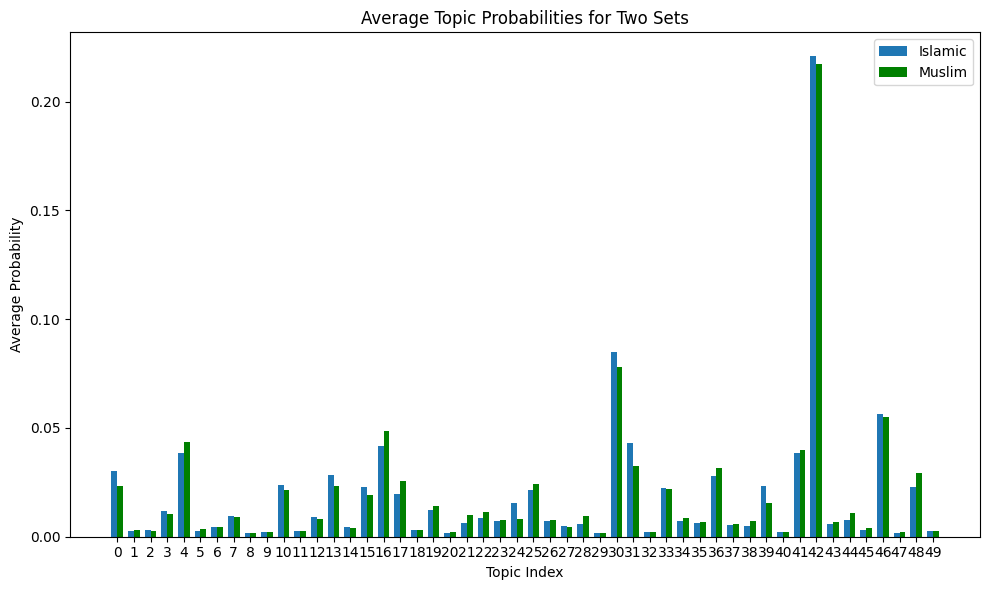

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_topics=50

# Simulate two sets of topic probabilities
set1_topic_probs = train_probs
set2_topic_probs = test_probs

# Calculate the mean topic probability for each topic in each set
mean_probs_set1 = np.mean(set1_topic_probs, axis=0)
mean_probs_set2 = np.mean(set2_topic_probs, axis=0)

# Create a bar chart to visualize the average topic probabilities for each set
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(num_topics)

bar1 = ax.bar(index, mean_probs_set1, bar_width, label='Islamic')
bar2 = ax.bar(index + bar_width, mean_probs_set2, bar_width, label='Muslim', color="green")

ax.set_xlabel('Topic Index')
ax.set_ylabel('Average Probability')
ax.set_title('Average Topic Probabilities for Two Sets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(np.arange(0, num_topics))  # Assuming topics are indexed from 1 to num_topics
ax.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


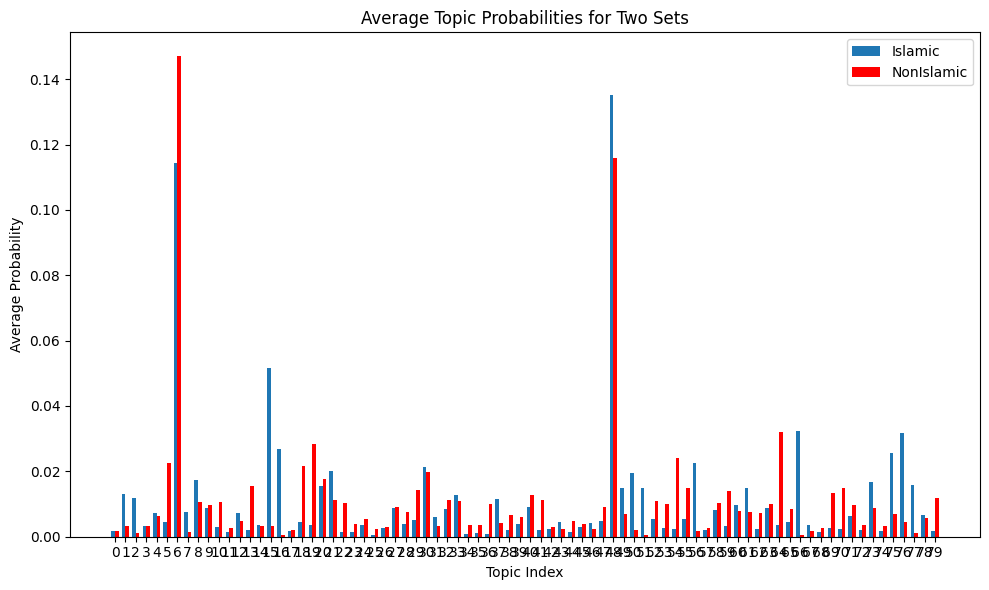

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_topics=80

# Simulate two sets of topic probabilities
set1_topic_probs = df[df['class'] == 1][topic_columns][:20000]
set2_topic_probs = df[df['class'] == 0][topic_columns][:20000]

# Calculate the mean topic probability for each topic in each set
mean_probs_set1 = np.mean(set1_topic_probs, axis=0)
mean_probs_set2 = np.mean(set2_topic_probs, axis=0)

# Create a bar chart to visualize the average topic probabilities for each set
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(num_topics)

bar1 = ax.bar(index, mean_probs_set1, bar_width, label='Islamic')
bar2 = ax.bar(index + bar_width, mean_probs_set2, bar_width, label='NonIslamic', color="Red")

ax.set_xlabel('Topic Index')
ax.set_ylabel('Average Probability')
ax.set_title('Average Topic Probabilities for Two Sets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(np.arange(0, num_topics))  # Assuming topics are indexed from 1 to num_topics
ax.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


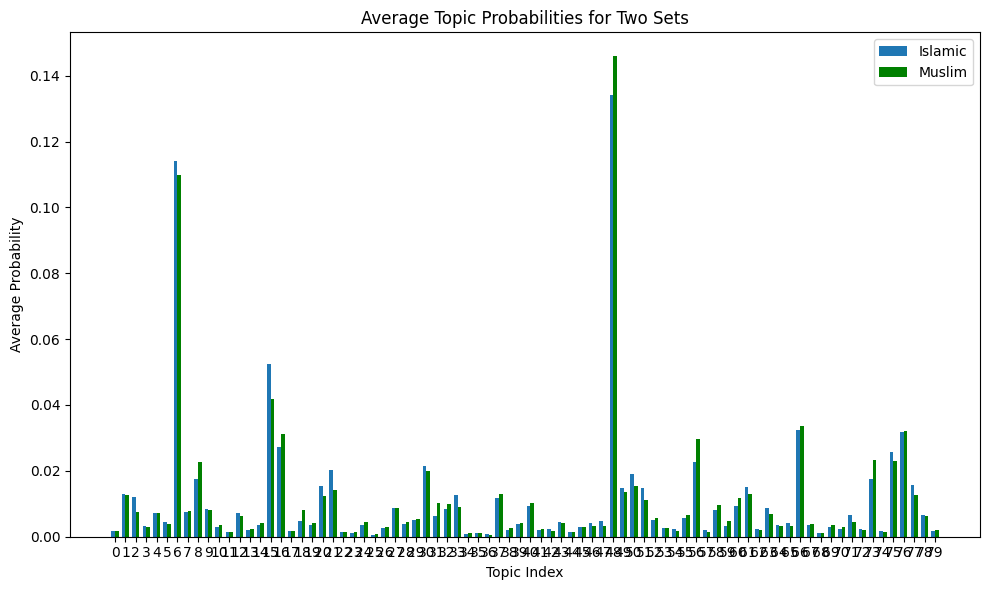

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_topics=80

test_data = pd.read_csv(f'/content/Muslim_submission.csv')
test_data["class"] = 1
test_data_clean, test_probs = clean_and_find_probs(test_data)

# Simulate two sets of topic probabilities
set1_topic_probs = df[df['class'] == 1][topic_columns]
set2_topic_probs = test_probs

# Calculate the mean topic probability for each topic in each set
mean_probs_set1 = np.mean(set1_topic_probs, axis=0)
mean_probs_set2 = np.mean(set2_topic_probs, axis=0)

# Create a bar chart to visualize the average topic probabilities for each set
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(num_topics)

bar1 = ax.bar(index, mean_probs_set1, bar_width, label='Islamic')
bar2 = ax.bar(index + bar_width, mean_probs_set2, bar_width, label='Muslim', color="green")

ax.set_xlabel('Topic Index')
ax.set_ylabel('Average Probability')
ax.set_title('Average Topic Probabilities for Two Sets')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(np.arange(0, num_topics))  # Assuming topics are indexed from 1 to num_topics
ax.legend()

plt.tight_layout()
plt.show()